In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

csv_file = "2_5_fabricio_tiktok30minuse"

data = pd.read_csv("../csv_files/" + csv_file + ".csv", encoding='latin-1')

In [160]:
# styling
plt.style.use('seaborn-darkgrid')
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'none'
mpl.rcParams['legend.edgecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['grid.alpha'] = 0.0
mpl.rcParams['figure.edgecolor'] = 'black'
mpl.rcParams['figure.subplot.bottom'] = 0.125
mpl.rcParams['figure.subplot.top'] = 0.9
mpl.rcParams['figure.subplot.left'] = 0.125
mpl.rcParams['figure.subplot.right'] = 0.9
mpl.rcParams['figure.subplot.wspace'] = 0.2
mpl.rcParams['figure.subplot.hspace'] = 0.2
mpl.rcParams['figure.figsize'] = (15, 5)

In [161]:
data = data[~(data["Protocol"].isin(["MDNS", "ICMP", "DHCP", "NTP", "SSDP", "ARP"])|data['Protocol'].isna())]
data["Protocol"].value_counts()

TCP        3796
TLSv1.2    3155
TLSv1.3     308
QUIC        137
DNS         102
UDP          63
NBNS          3
HTTP          2
Name: Protocol, dtype: int64

In [162]:
source = data["Destination"].value_counts().idxmax()
source

'10.133.31.176'

In [163]:
data.iloc[12]

No.                                                  101
Time                                            2.505488
Source         ec2-54-83-207-163.compute-1.amazonaws.com
Destination                                10.133.31.176
Protocol                                         TLSv1.2
Length                                               110
Info                                    Application Data
Name: 100, dtype: object

In [164]:
# add new column host for ip host

def find_host(row):
    # find non-source ip address
    ip = str(row["Destination"] if row["Destination"] != source else row["Source"])

    # akamai
    if any(x in ip for x in ['google', 'gmail', '1e100', 'app-measurement']):
        return "Google"
    elif any(x in ip for x in ['amazon', 'aws']):
        return "Amazon"
    elif any(x in ip for x in ['apple', 'apple-dns', 'aaplimg']):
        return "Apple"
    elif any(x in ip for x in ['akamai', 'akadns']):
        return "Akamai"
    elif any(x in ip for x in ['facebook', 'fbcdn', 'instagram']):
        return "Facebook"
    else:
        return "other"

data["Host"] = data.apply(find_host, axis=1)
data["Host"].value_counts()


other     3597
Amazon    2437
Google     772
Apple      643
Akamai     117
Name: Host, dtype: int64

In [165]:
data[data['Host'] == 'other']['Source'].value_counts()

10.133.31.176                          1777
162.159.135.234                        1161
edge-web.dual-gslb.spotify.com          282
edge-web-guc3.dual-gslb.spotify.com      72
cdn.discordapp.com                       72
cs39902whoism-fxb7665.slack.com          55
ns1.carleton.edu                         51
edgeapi.slack.com                        42
notify.adobe.io                          34
17.57.144.138                            25
discord.com                              23
104.26.2.138                              3
Name: Source, dtype: int64

Buckets time to to 1 second or 5 second chunks

In [166]:
bucket_size = 5
time_series = np.arange(0, data['Time'].max(), bucket_size)

# UNCOMMENT APPROPRIATE CODE FOOR CSV FORMAT
# if saved as seconds, convert to integer seconds
data['Time'] = data['Time'].round().astype(int)

# if saved as datetime, convert to integer seconds
# times = pd.to_datetime(data['Time'])
# data['Time'] = (times-times[0]).dt.seconds

# round seconds to nearest 5
data['Time'] = data['Time'].apply(lambda x: round(x/bucket_size)*bucket_size)
data['Time']

51           0
52           0
85           0
86           0
91           0
          ... 
345093    1875
345273    1875
345274    1875
345381    1875
345382    1875
Name: Time, Length: 7566, dtype: int64

In [167]:
# separate data by host
fb = data.where(data['Host'] == 'Facebook')['Length'].fillna(0)
goog = data.where(data['Host'] == 'Google')['Length'].fillna(0)
amz = data.where(data['Host'] == 'Amazon')['Length'].fillna(0)
aapl = data.where(data['Host'] == 'Apple')['Length'].fillna(0)
ak = data.where(data['Host'] == 'Akamai')['Length'].fillna(0)
oth = data.where(data['Host'] == 'other')['Length'].fillna(0)

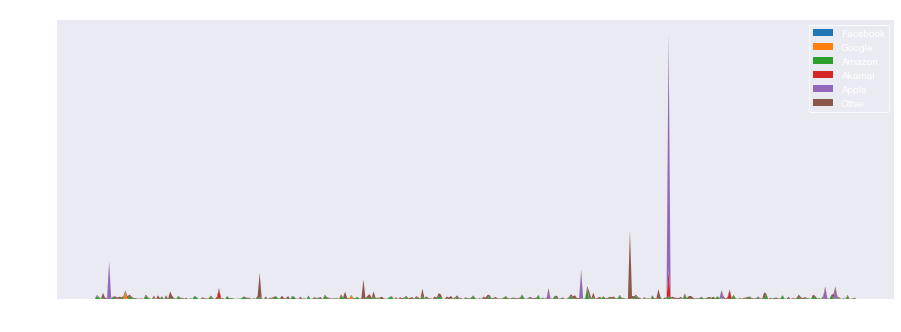

In [168]:
# plot packet length by time
size_data = pd.DataFrame({'Time': data['Time'], 'Facebook': fb, 'Google': goog, 'Amazon': amz, 'Akamai': ak, 'Apple': aapl, 'Other': oth})
size_data = size_data.groupby('Time', dropna=False, as_index=False).sum()
# add zeros to missing data
size_data = size_data.set_index('Time').reindex(time_series, fill_value=0)

fig, ax = plt.subplots()

ax.stackplot(time_series, 
            size_data['Facebook'], size_data['Google'], size_data['Amazon'], size_data['Akamai'], size_data['Apple'], size_data['Other'], 
            labels=['Facebook', 'Google', 'Amazon', 'Akamai', 'Apple', 'Other'])

# ax.stackplot(data['Time'], fb, goog, amz, ak, labels=['Facebook', 'Google', 'Amazon', 'Akamai'])
ax.legend(loc='upper right')
ax.set_title(csv_file + " (5s)")
ax.set_xlabel('Second')
ax.set_ylabel('Total packet throughput (bytes)')
#ax.set_yscale('log')


plt.show()

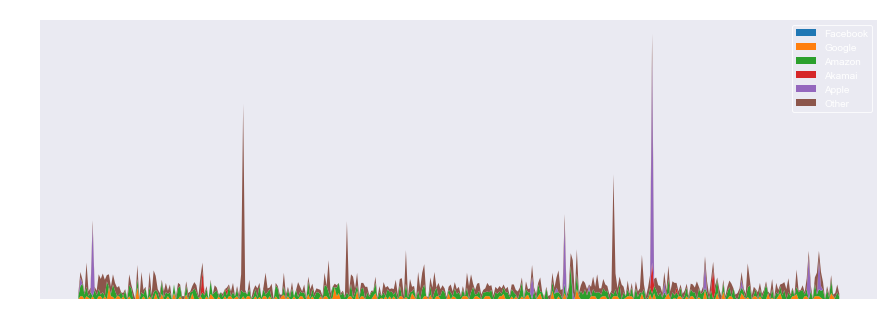

In [169]:
# count number of packets per second by host
count_data = pd.DataFrame({'Time': data['Time'], 
                           'Facebook': fb[fb > 0], 'Google': goog[goog > 0], 'Amazon': amz[amz > 0], 
                           'Akamai': ak[ak > 0], 'Apple': aapl[aapl > 0], 'Other': oth[oth > 0]})
count_data = count_data.groupby('Time', dropna=False, as_index=False).count()
count_data = count_data.set_index('Time').reindex(time_series, fill_value=0)

fig, ax = plt.subplots()
ax.stackplot(time_series,
            count_data['Facebook'], count_data['Google'], count_data['Amazon'], count_data['Akamai'], count_data['Apple'], count_data['Other'],
            labels=['Facebook', 'Google', 'Amazon', 'Akamai', 'Apple', 'Other'])

ax.legend(loc='upper right')
ax.set_title(csv_file + " (5s)")
ax.set_xlabel('Second')
ax.set_ylabel('Total packet count')
# ax.set_yscale('log')

plt.show()
